# Comparación de Métodos de Predicción de Series Temporales aplicados a Acciones de MERVAL 

## Caso ALUA.BA (Aluar Aluminio Argentino S.A.I.C.) Período 2015-2021.

En este cuaderno se comparan distintos métodos de predicción de series temporales para un caso de Acciones de MERVAL obtenidas del servicio Yahoo Finance!.

El objetivo es comparar desde métodos clásicos como SARIMA hasta los más recientes como [Prophet](https://facebook.github.io/prophet/) de Facebook.

Se trata el problema de predicción de una manera general sin aplicar técnicas específicas de modelos matemáticos financieros o conocimientos del dominio financiero o del mercado bursátil, por lo tanto es trasladable a cualquier problema de series temporales univariable.

Cada serie temporal contiene los datos de un período:

- **Apertura (Open)**:
- **Alto (High)**:
- **Bajo (Low)**:
- **Cierre (Close)**:
- **Precio de Cierre Ajustado (Adj)**:
- **Volumen (Volume)**:

In [1]:
symbol = 'ALUA.BA' #ALUA.BA Aluar Aluminio Argentino S.A.I.C. 
data_source='yahoo'
start_date = '2015-01-01'
end_date = None

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit

In [3]:
STEPS_TO_PREDICT = 64

## 1. Descarga del dataset

In [4]:
from pandas_datareader import data
import fix_yahoo_finance as yf

yf.pdr_override() 
df = data.get_data_yahoo(symbol, start_date, end_date)
df.head(5)

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,7.54464,7.81250,7.41071,7.80357,6.517592,334621
2015-01-05,7.81250,7.81250,7.41071,7.51786,6.278966,157214
2015-01-06,7.50893,7.50893,7.23214,7.40178,6.182015,157115
2015-01-07,7.14286,7.53571,7.14286,7.53571,6.293874,181736
2015-01-08,7.71428,7.71428,7.36607,7.53571,6.293874,288559


In [5]:
#FIXME! Resampling

In [6]:
series_col = 'Close'
series = df[series_col]

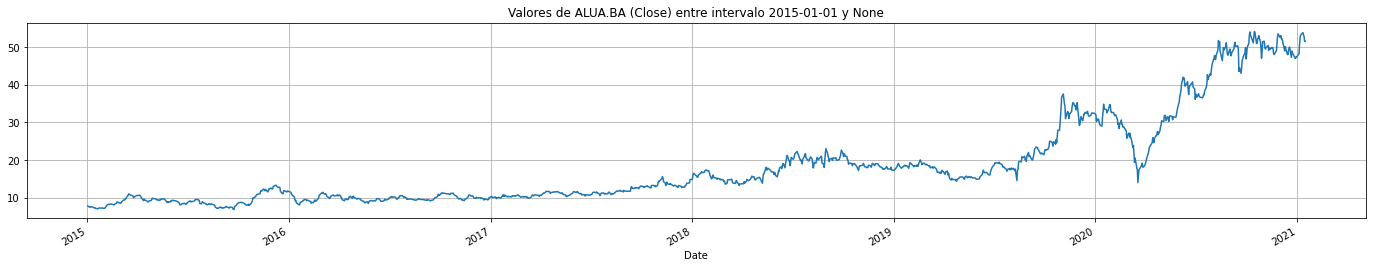

In [7]:
fig,axes = plt.subplots(1,1,figsize=(24,4))
axes.set_title("Valores de %s (%s) entre intervalo %s y %s" % (symbol,series_col,start_date,end_date) )
series.plot(ax=axes,grid=True)
plt.show()

## 2. Separación del Dataset en Entrenamiento y Evaluación

In [8]:
def split_dataset(series, train_split):
  total_samples = len(series)
  split_point = int(train_split * total_samples)
  train, test = series[0:split_point], series[split_point:]
  return train, test

Train (2015-12-2019-3-19): 1030 muestras.
Test (2019-320-2021-1-15): 442 muestras


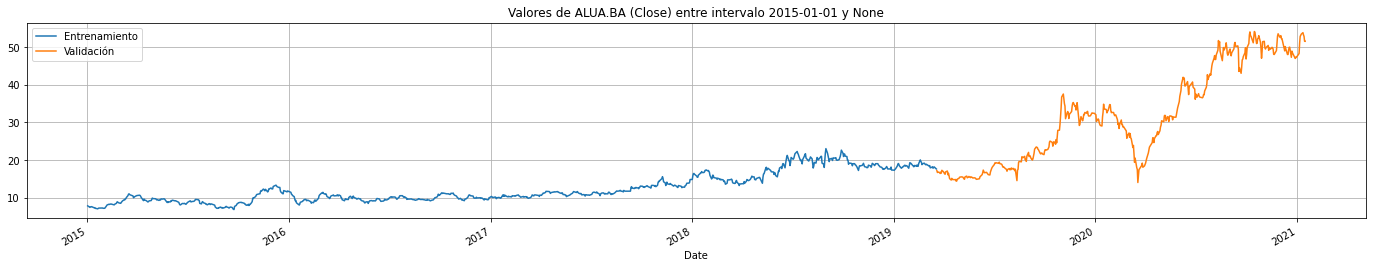

In [9]:
TRAIN_TEST_SPLIT = 0.7
train,test = split_dataset(series,TRAIN_TEST_SPLIT)
train_start = "%d-%d%d" % (train.index[0].year,train.index[0].month,train.index[0].day)
train_end = "%d-%d-%d" % (train.index[-1].year,train.index[-1].month,train.index[-1].day)
test_start = "%d-%d%d" % (test.index[0].year,test.index[0].month,test.index[0].day)
test_end = "%d-%d-%d" % (test.index[-1].year,test.index[-1].month,test.index[-1].day)
print("Train (%s-%s): %d muestras." % (train_start, train_end, len(train) ) )
print("Test (%s-%s): %d muestras" % (test_start, test_end, len(test) ) )

fig,axes = plt.subplots(1,1,figsize=(24,4))
axes.set_title("Valores de %s (%s) entre intervalo %s y %s" % (symbol,series_col,start_date,end_date) )
train.plot(ax=axes,grid=True,label="Entrenamiento")
test.plot(ax=axes,grid=True,label="Validación")
axes.legend(["Entrenamiento","Validación"])
plt.show()

### 3. Evaluación del Dataset

Cada modelo será evaluado sobre el Test set con las siguientes métricas:

- Mean Square Error ($MSE$)
- Root Mean Square Error ($RMSE$)
- Mean Absolute Error ($MAE$)
- Mean Absolute Percentage Error ($MAPE$)
- R Squared ($R^2$)

In [10]:
model_metric_results = {}

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

def report_model(history,predictions,test):
  n_history = len(history)
  n_predicted = len(predictions)
  plt.figure(figsize=(24,4))
  plt.grid(which="Both")
  plt.plot(np.arange(n_history),history)
  plt.plot(np.arange(n_history-n_predicted,n_history),predictions)
  plt.legend(["Observación","Predicción"])
  plt.show()

  # report performance
  y_true, y_pred = np.array(test), np.array(predictions)  
  mse = metrics.mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  mae = metrics.mean_absolute_error(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  r2 = metrics.r2_score(y_true, y_pred)
  print( 'MSE: %.3f ' % mse)
  print( 'RMSE: %.3f ' % rmse)
  print( 'MAE: %.3f ' % mae)
  print( 'MAPE: %.3f ' % mape)
  print( 'R2: %.3f ' % r2)

  return mse,rmse,mae,mape,r2

Modelo de Persistencia (Baseline).

In [12]:
def baseline_walk_forward(train,validation):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):  

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict
    yhat = history[-1]
    for j in range(n_steps):
      predictions.append(yhat)
      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)
  return history, predictions

start_time=timeit.default_timer()
history, predictions = baseline_walk_forward(train,test)
prediction_time = timeit.default_timer()-start_time
training_time = 0

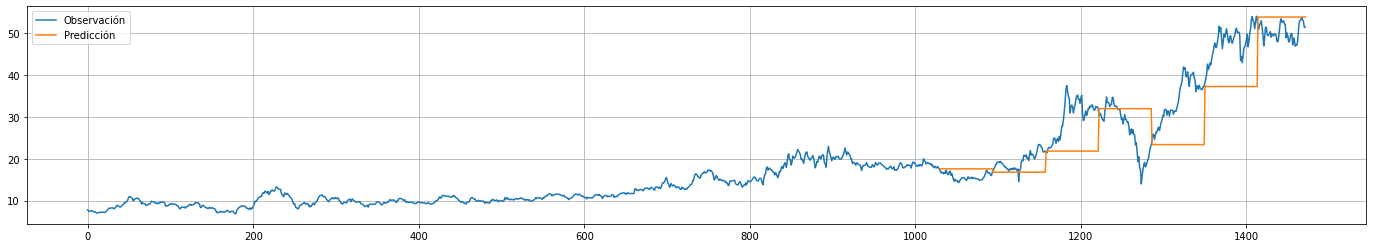

MSE: 62.663 
RMSE: 7.916 
MAE: 6.161 
MAPE: 19.488 
R2: 0.611 


In [13]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [14]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 0
Tiempo de Predicción: 0.0002104739996866556


In [15]:
model_metric_results["baseline"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Modelo de base (Persistencia)"
}

## 4. Análisis Exploratorio de Datos

### Resumen de 5 Números

In [16]:
train.describe()

count    1030.000000
mean       12.393756
std         3.921479
min         6.820000
25%         9.500000
50%        10.850000
75%        14.900000
max        23.000000
Name: Close, dtype: float64

### Gráfico de Tendencia.

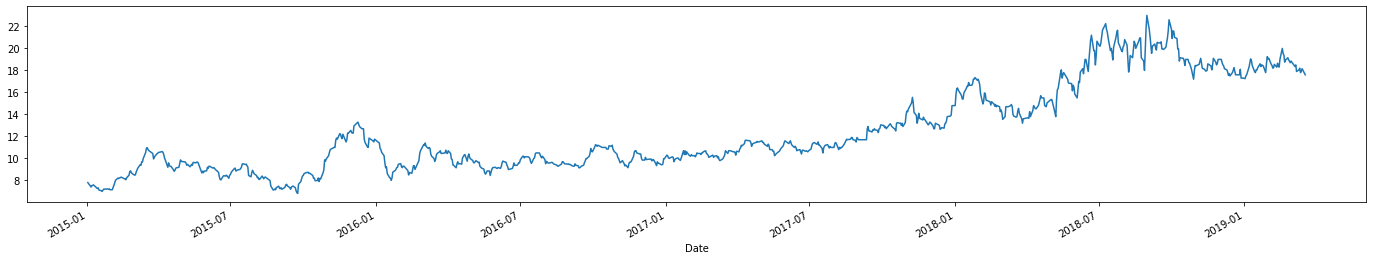

In [17]:
plt.figure(figsize=(24,4))
train.plot()
plt.show()

### Histograma y Estimación de Densidad de Kernel

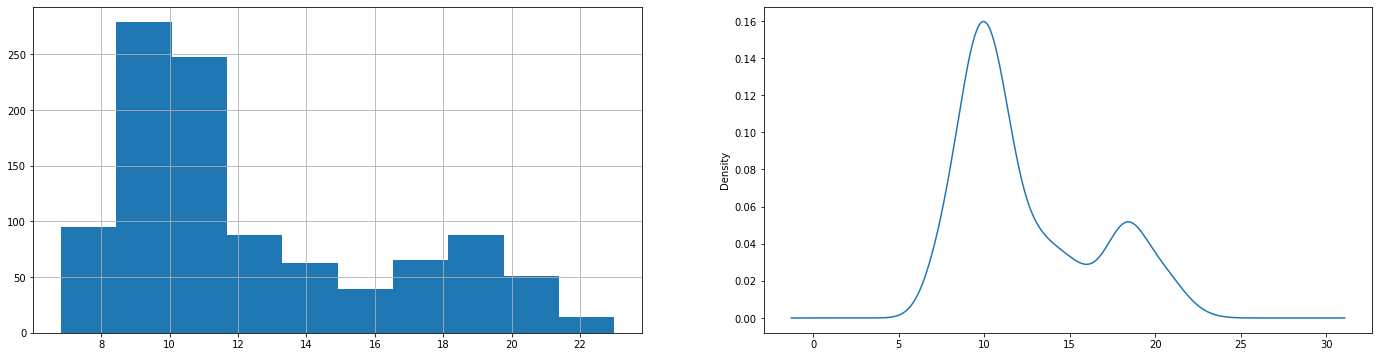

In [18]:
fig,axes = plt.subplots(1,2,figsize=(24,6))
train.hist(ax=axes[0])
train.plot(kind='kde',ax=axes[1])
plt.show()

Observaciones:
- Se vé que no es una Gaussiana, por lo que se espera la transformación Box-Cox mejore el desempeño de los algoritmos de la familia SARIMA.

### Diagrama de Box y Whisker

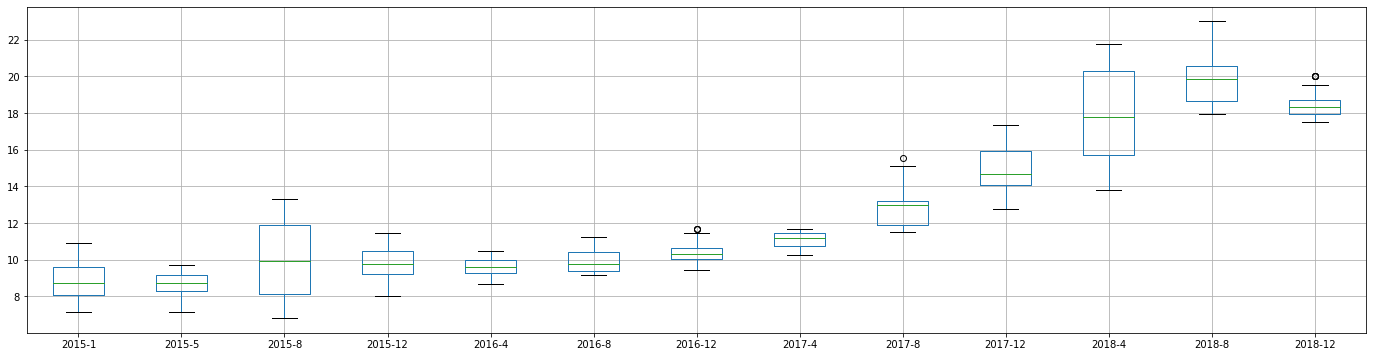

In [19]:
periods = pd.DataFrame()
for name,group in train.groupby(pd.Grouper(freq= '120D')):
  period_name = str(name.year)+"-"+str(name.month)
  periods[period_name] = group.sample(60,replace=True).values
fig,axes = plt.subplots(figsize=(24,6))
periods.boxplot(ax=axes)

Observaciones:
- Se vé una tendencia ascendente, probablemente no lineal. Esto sugiere la necesidad de una diferenciación previa de los datos para usar en los modelos de la familia SARIMA.

## Entrenamiento de Modelos

### Modelo ARIMA



El modelo ARIMA requiere que una serie sea estacionaria. Para verificar si la serie es estacionaria se puede realizar el test de Dickey-Fuller Aumentado.

In [20]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data):
  # check if stationary
  result = adfuller(data)
  print( 'ADF Statistic: %f' % result[0])
  print( 'p-value: %f' % result[1])
  print( 'Critical Values:'  )
  for key, value in result[4].items():
    print( '\t%s: %.3f' % (key, value))

  if result[0] < result[4]['1%']:
    print("Se rechaza H0. La serie es estacionaria.")    
  else:
    print("No se rechaza H0. La serie no es estacionaria.")    

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
test_stationarity(train)

ADF Statistic: -1.378470
p-value: 0.592553
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
No se rechaza H0. La serie no es estacionaria.


Una forma de hacer la serie estacionaria es aplicar una diferencia.

In [22]:
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return pd.Series(diff)

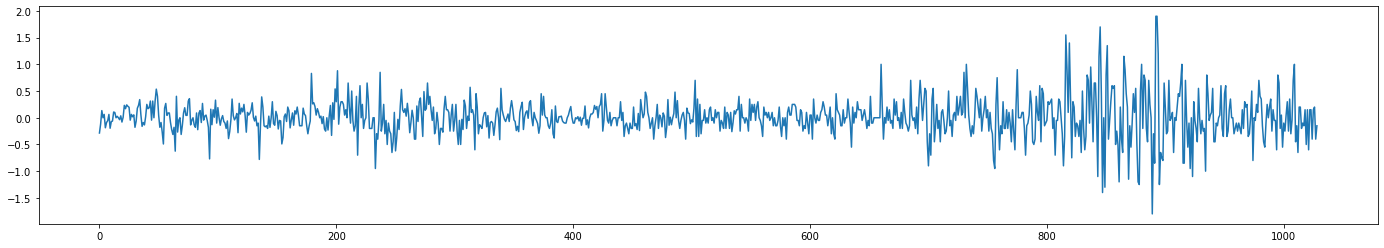

In [23]:
train_diff = difference(train)
plt.figure(figsize=(24,4))
plt.plot(train_diff)

In [24]:
test_stationarity(train_diff)

ADF Statistic: -6.662185
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Se rechaza H0. La serie es estacionaria.


Rechazar la Hipótesis Nula significa con un nivel de significancia menor al 1% implica que el proceso no tiene raíz unitaria, y por lo tanto la serie es estacionaria y no tiene una estructura dependiente del tiempo.

In [25]:
# FIXME probar otros métodos.

El próximo paso es seleccionar los valores de lag para Autoregresión (AR) y Promedio Móvil (MA), parámetros p y q respectivamente.
Un método es estudiando los gráficos de las funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF).

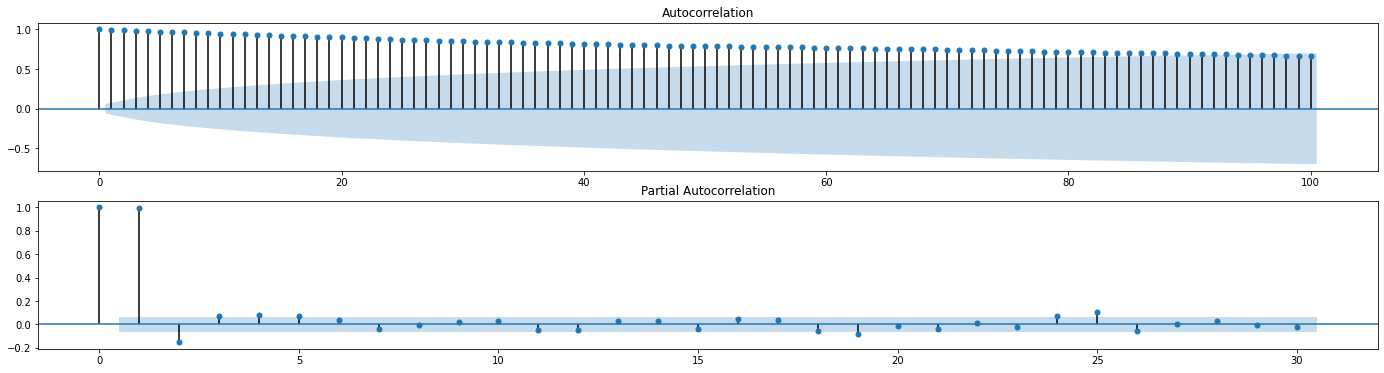

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig,axes = plt.subplots(2,1,figsize=(24,6))
plot_acf(train, lags=100, ax=axes[0])
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

- El gráfico de ACF muestra lags significativos hasta órdenes muy altos, cercanos a 80.
- El gráfico de PACF muestra lags significativos hasta el 1.

In [27]:
from statsmodels.tsa.arima_model import ARIMA
from tqdm.notebook import tqdm

def arima_walk_forward(train,validation,p,d,q):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  bar = tqdm(total=len(x_val_values))

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict    
    model = ARIMA(history, order=(p,d,q))
    model = model.fit(disp=0)
    yhat = model.forecast(n_steps)[0]
    for j in range(n_steps):
      predictions.append(yhat[j])      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)
    bar.update(n_steps)

  return history, predictions

Se entrenará un modelo sobre una partición del set de entrenamiento.

In [28]:
x_train,x_val = split_dataset(train,0.8)

Uno de los problemas de ARIMA es que el entrenamiento es lento para órdenes altos, por lo tanto, se intentará con valores inferiores a 10 para tener tiempos de entrenamiento aceptables.

In [29]:
p = 10
d = 1
q = 1
history, predictions = arima_walk_forward(x_train,x_val,p,d,q)

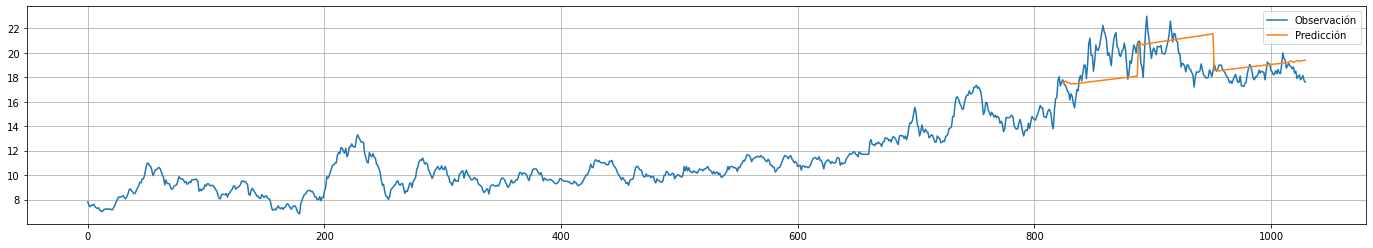

MSE: 3.073 
RMSE: 1.753 
MAE: 1.376 
MAPE: 7.190 
R2: -0.665 


In [30]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,x_val)

#### Análisis de Residuales

In [31]:
residuals = [x_val[i]-predictions[i] for i in range(len(x_val))]
residuals = pd.DataFrame(residuals)
residuals.describe()

,0
count,206.000000
mean,-0.210302
std,1.744656
min,-4.127633
25%,-1.169496
50%,-0.454986
75%,0.562209
max,4.490030


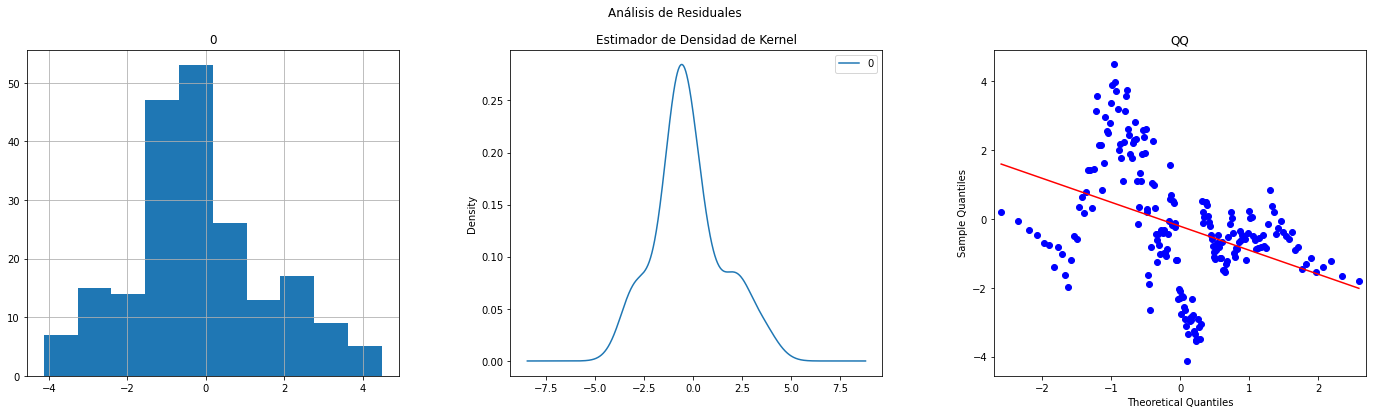

In [32]:
from statsmodels.graphics.gofplots import qqplot

fig,axes = plt.subplots(1,3,figsize=(24,6))
plt.suptitle("Análisis de Residuales")
axes[0].set_title("Histograma")
residuals.hist(ax=axes[0])
axes[1].set_title("Estimador de Densidad de Kernel")
residuals.plot(kind='kde', ax=axes[1])
axes[2].set_title("QQ")
qqplot(residuals, line= 'r', ax=axes[2] )
plt.show()

Idealmente se espera que los residuales tengan una distribución gaussiana de media cero. No es exactamente una Gaussiana, pero la media es próxima a cero.

- FIXME: ver qué pasa con el QQPlot.

#### Entrenamiento con dataset completo

In [33]:
start_time=timeit.default_timer()
model = ARIMA(train.values, order=(p,d,q))
model = model.fit(disp=0)
model.save( 'arima.pkl' )
training_time = timeit.default_timer()-start_time

#### Validación contra Test Set

In [34]:
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

def predict_with_arima(model,train,test,p,q,d):
  bar = tqdm(total=len(test))
  
  history = [x for x in train.values]
  predictions = []
  
  yhat = model.forecast(STEPS_TO_PREDICT)[0]
  for j in range(STEPS_TO_PREDICT):
    predictions.append(yhat[j])

  for i in range(STEPS_TO_PREDICT,len(test),STEPS_TO_PREDICT):
    # predict
    n_steps = min(STEPS_TO_PREDICT,len(test)-i)
    model = ARIMA(history, order=(p,d,q))
    model = model.fit(disp=0)
    yhat = model.forecast(steps=n_steps)[0]
    for j in range(n_steps):
      predictions.append(yhat[j])
      # observation
      obs = test[i+j]
      history.append(obs)
    bar.update(n_steps)
  return history,predictions

In [35]:
start_time=timeit.default_timer()
model = ARIMAResults.load( 'arima.pkl' )
history,predictions = predict_with_arima(model,train,test,p,q,d)
prediction_time = timeit.default_timer()-start_time

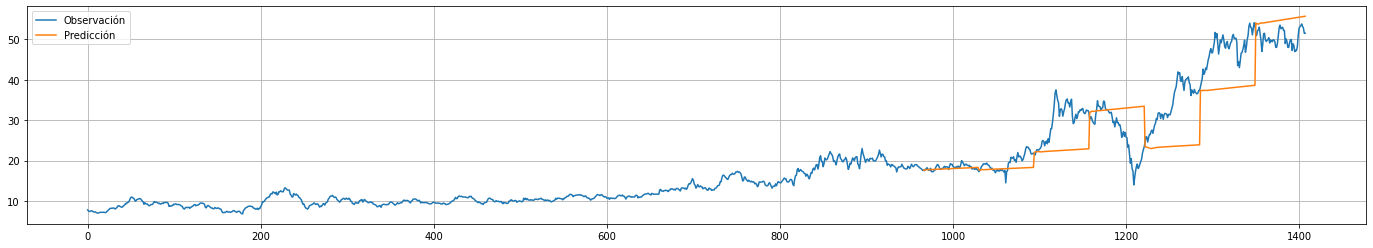

MSE: 60.374 
RMSE: 7.770 
MAE: 6.083 
MAPE: 19.315 
R2: 0.625 


In [36]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [37]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 3.3742280550000032
Tiempo de Predicción: 26.851007670999934


In [38]:
model_metric_results["ARIMA"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "ARIMA (p=%d,d=%d,q=%d)" % (p,d,q)
}

### Preparación de Dataset para modelos RNN

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)
np.random.seed(42)

In [40]:
WINDOW_SIZE = STEPS_TO_PREDICT

In [41]:
train.shape,test.shape

((1030,), (442,))

Feature scaling.

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [43]:
TRAIN_VAL_SPLIT = 0.8
split_point = int(TRAIN_VAL_SPLIT*len(scaled_train))
ts_train = scaled_train[0:split_point]
ts_val = scaled_train[split_point:]

In [44]:
def prepare_dataset(data,window_size,horizon):
  X,y = [], []
  n = len(data)
  for i in range(n-window_size-horizon):
    X.append(data[i:(i+window_size)])
    y.append(data[(i+window_size):(i+window_size+horizon)])
  return np.array(X), np.array(y)

x_train, y_train = prepare_dataset(ts_train,WINDOW_SIZE,STEPS_TO_PREDICT)
x_val, y_val = prepare_dataset(ts_val,WINDOW_SIZE,STEPS_TO_PREDICT)

x_train.shape,y_train.shape

((696, 64, 1), (696, 64, 1))

Convertir los datos a tf.data mejora el rendimiento con GPU (ver: [Guide to Data Perfomance in Google Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb)).

In [45]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_uv = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_uv = train_uv.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_uv = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_uv = val_uv.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

### Modelo LSTM

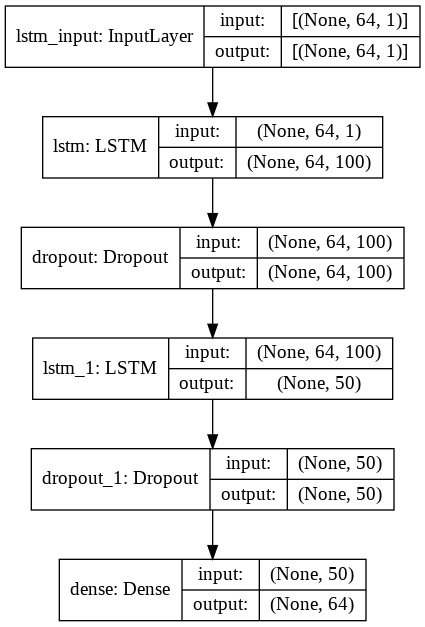

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=STEPS_TO_PREDICT),
])
model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('lstm_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 7s 23ms/step - loss: 0.0345 - val_loss: 0.0154
Epoch 2/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 3/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0076 - val_loss: 0.0387
Epoch 4/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0056 - val_loss: 0.1122
Epoch 5/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0049 - val_loss: 0.0826
Epoch 6/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 0.0779
Epoch 7/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0037 - val_loss: 0.0839
Epoch 8/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0939
Epoch 9/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0757
Epoch 10/150
100/100 [==============================] - 1s 14ms/step - loss: 0.002

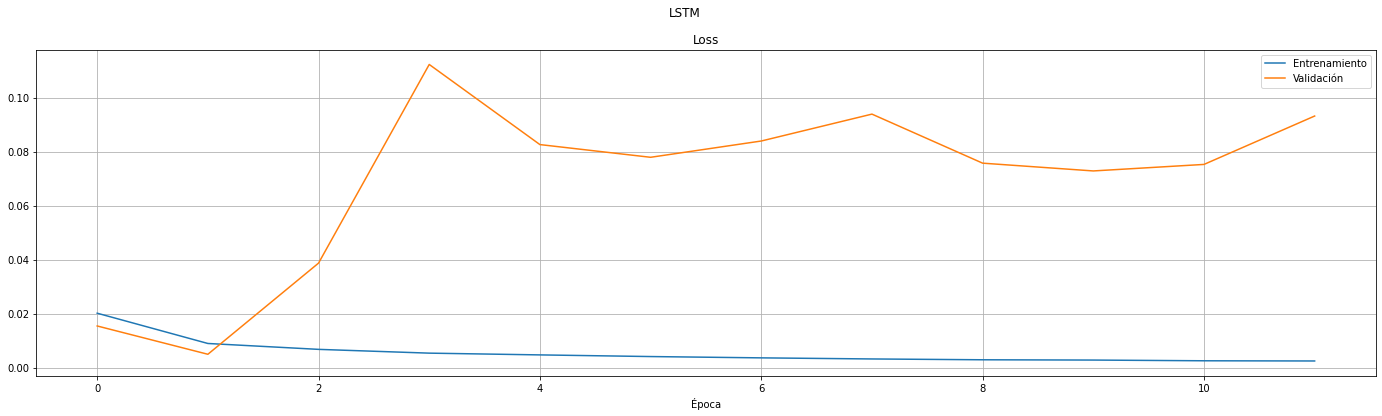

In [48]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("LSTM")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

In [49]:
model = tf.keras.models.load_model('lstm_best.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 64, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
Total params: 74,264
Trainable params: 74,264
Non-trainable params: 0
_________________________________________________________________


In [50]:
def predict_with_rnn(model,scaler,train,test):
  history = [x for x in train.values]
  predictions = []
  train_scaled = scaler.transform(train.values.reshape(-1, 1))
  test_scaled = scaler.transform(test.values.reshape(-1, 1))
  tmp_input = np.vstack([train_scaled[-WINDOW_SIZE:],test_scaled])
  for i in range(0,test_scaled.shape[0],STEPS_TO_PREDICT):
    yhat = model.predict(tmp_input[i:(i+WINDOW_SIZE)].reshape(1,WINDOW_SIZE, 1)).T
    yhat = scaler.inverse_transform(yhat).flatten()
    predictions.extend(yhat)
  predictions = np.array(predictions[:len(test)])
  return history,predictions

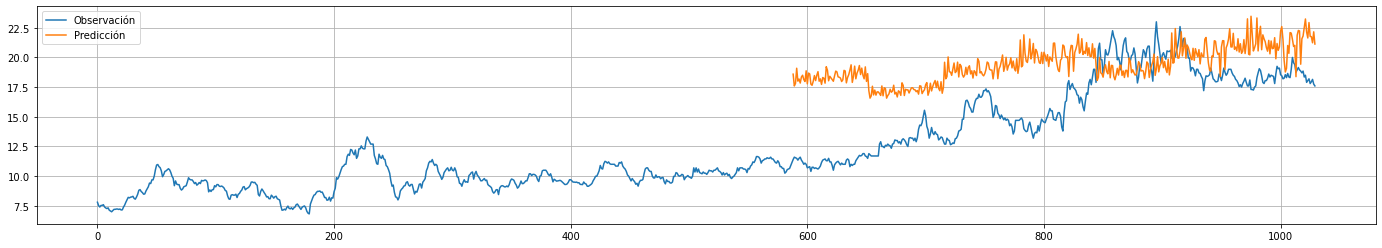

MSE: 291.479 
RMSE: 17.073 
MAE: 13.370 
MAPE: 35.068 
R2: -0.811 


In [51]:
start_time = timeit.default_timer()
model = tf.keras.models.load_model('lstm_best.h5')
history,predictions = predict_with_rnn(model,scaler,train,test)
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [52]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["LSTM"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "LSTM (sin reentrenar)"
}

Tiempo de Entrenamiento: 20.74055405399986
Tiempo de Predicción: 1.4567058800002997


### Modelo LSTM Bidireccional

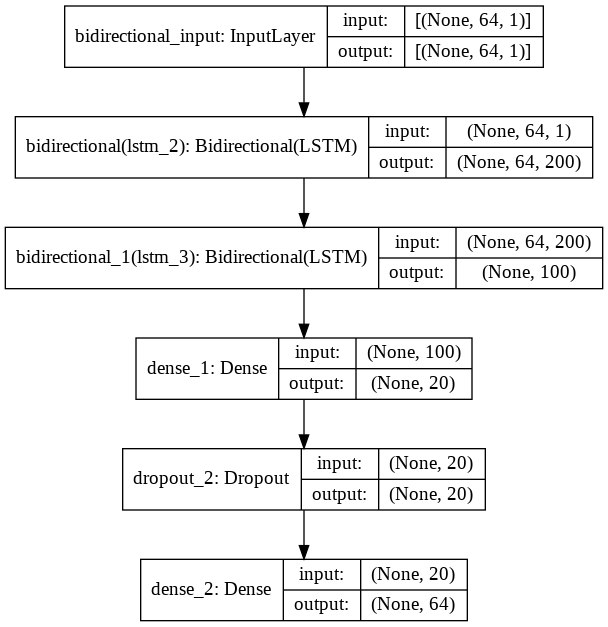

In [53]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(100,return_sequences=True),input_shape=x_train.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=STEPS_TO_PREDICT),
])

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('lstm_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 9s 38ms/step - loss: 0.0517 - val_loss: 0.3064
Epoch 2/150
100/100 [==============================] - 3s 25ms/step - loss: 0.0209 - val_loss: 0.2449
Epoch 3/150
100/100 [==============================] - 2s 25ms/step - loss: 0.0180 - val_loss: 0.2170
Epoch 4/150
100/100 [==============================] - 3s 25ms/step - loss: 0.0123 - val_loss: 0.1577
Epoch 5/150
100/100 [==============================] - 3s 25ms/step - loss: 0.0082 - val_loss: 0.1222
Epoch 6/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0066 - val_loss: 0.0995
Epoch 7/150
100/100 [==============================] - 3s 25ms/step - loss: 0.0055 - val_loss: 0.0876
Epoch 8/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0048 - val_loss: 0.0840
Epoch 9/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0047 - val_loss: 0.0779
Epoch 10/150
100/100 [==============================] - 3s 26ms/step - loss: 0.004

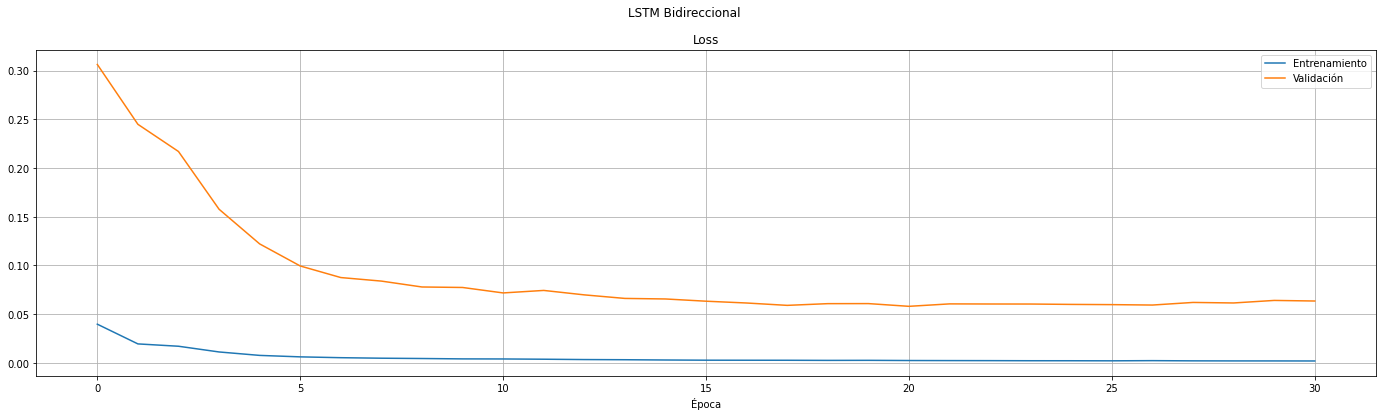

In [55]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("LSTM Bidireccional")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

In [56]:
def predict_with_rnn2(model,scaler,train,test):
  history = [x for x in train.values]
  predictions = []
  train_scaled = scaler.transform(train.values.reshape(-1, 1))
  test_scaled = scaler.transform(test.values.reshape(-1, 1))
  tmp_input = np.vstack([train_scaled[-WINDOW_SIZE:],test_scaled])
  for i in range(0,test_scaled.shape[0],STEPS_TO_PREDICT):
    yhat = model.predict(tmp_input[i:(i+WINDOW_SIZE)].reshape(1,WINDOW_SIZE, 1)).T.reshape(WINDOW_SIZE, 1)
    yhat = scaler.inverse_transform(yhat).flatten()
    predictions.extend(yhat)
  predictions = np.array(predictions[:len(test)])
  return history,predictions

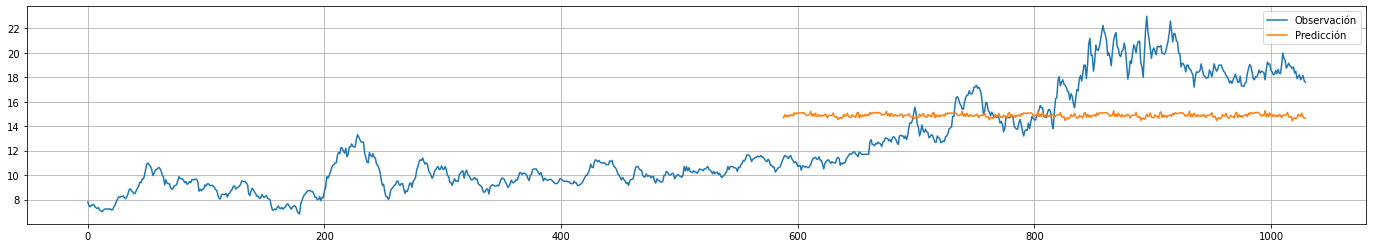

MSE: 447.765 
RMSE: 21.160 
MAE: 16.946 
MAPE: 44.506 
R2: -1.781 


In [57]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('lstm_best.h5')
history,predictions = predict_with_rnn2(model,scaler,train,test)
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [58]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["LSTM-Bi"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "LSTM Bidireccional (sin reentrenar)"
}

Tiempo de Entrenamiento: 87.26663182799984
Tiempo de Predicción: 2.5256501549997665


### Modelo GRU

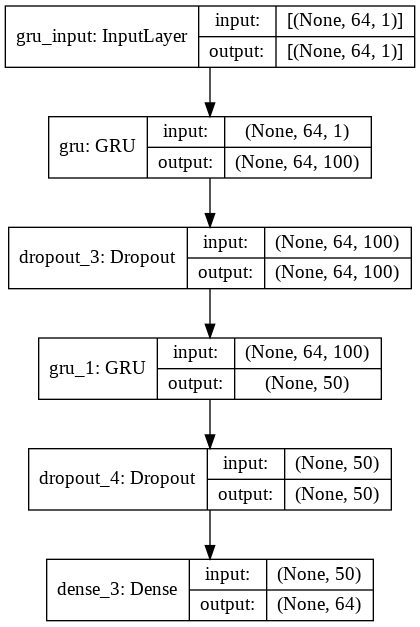

In [59]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=x_train.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=STEPS_TO_PREDICT),
])

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('gru_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 5s 19ms/step - loss: 0.0341 - val_loss: 0.0079
Epoch 2/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0097 - val_loss: 0.0053
Epoch 3/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 4/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0049
Epoch 5/150
100/100 [==============================] - 1s 13ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0075 - val_loss: 0.0123
Epoch 7/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0067 - val_loss: 0.0571
Epoch 8/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0784
Epoch 9/150
100/100 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0864
Epoch 10/150
100/100 [==============================] - 1s 13ms/step - loss: 0.004

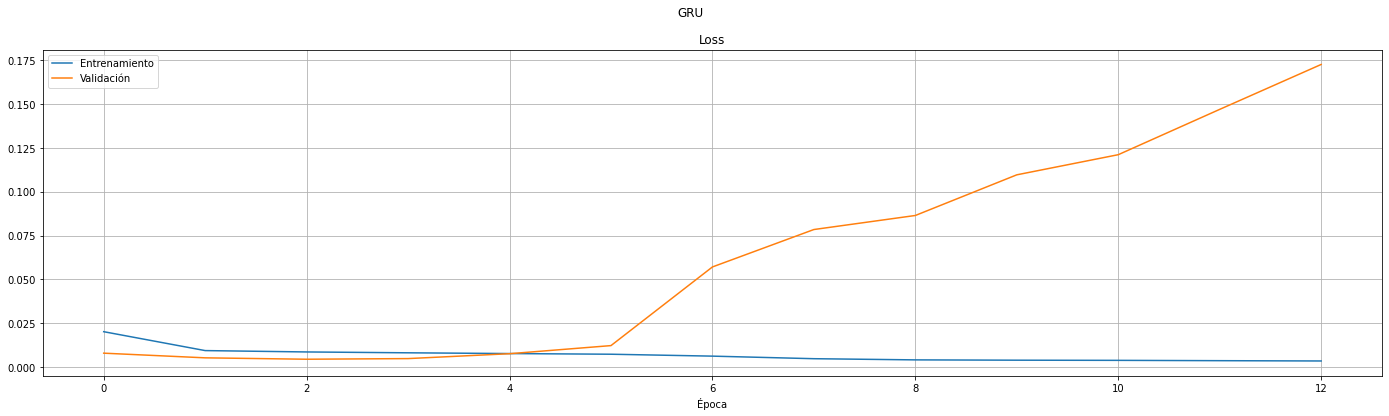

In [61]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("GRU")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

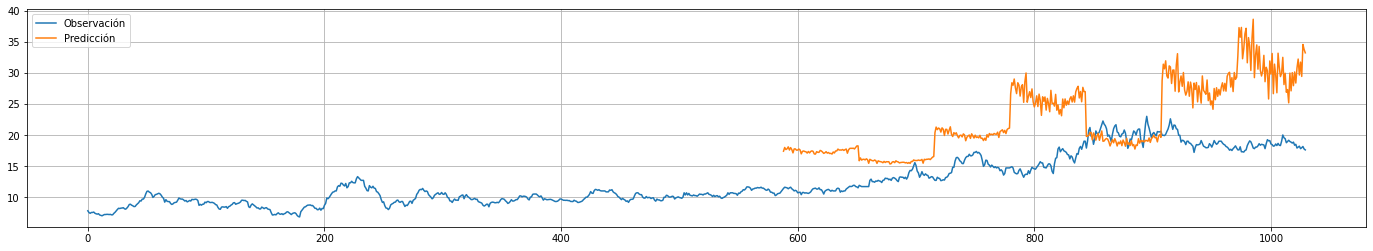

MSE: 169.124 
RMSE: 13.005 
MAE: 10.432 
MAPE: 28.679 
R2: -0.051 


In [62]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('gru_best.h5')
history,predictions = predict_with_rnn(model,scaler,train,test)
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [63]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["GRU"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "GRU (sin reentrenar)"
}

Tiempo de Entrenamiento: 19.531193582000014
Tiempo de Predicción: 1.3657522809999136


### Autoencoder LSTM

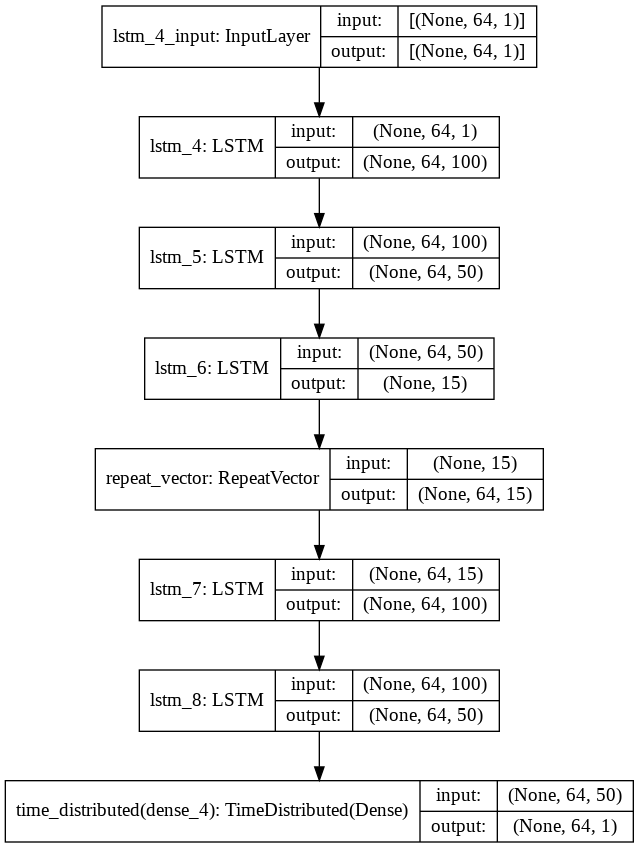

In [64]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, input_shape=x_train.shape[-2:], return_sequences=True),
  tf.keras.layers.LSTM(units=50,return_sequences=True),
  tf.keras.layers.LSTM(units=15),
  tf.keras.layers.RepeatVector(y_train.shape[1]),
  tf.keras.layers.LSTM(units=100,return_sequences=True),
  tf.keras.layers.LSTM(units=50,return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [65]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('lstm_autoenc_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 10s 44ms/step - loss: 0.0163 - val_loss: 0.0348
Epoch 2/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0069 - val_loss: 0.0977
Epoch 3/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0051 - val_loss: 0.0727
Epoch 4/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0043 - val_loss: 0.1008
Epoch 5/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0039 - val_loss: 0.0664
Epoch 6/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0033 - val_loss: 0.0716
Epoch 7/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0028 - val_loss: 0.0641
Epoch 8/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0024 - val_loss: 0.0658
Epoch 9/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0026 - val_loss: 0.0442
Epoch 10/150
100/100 [==============================] - 3s 27ms/step - loss: 0.00

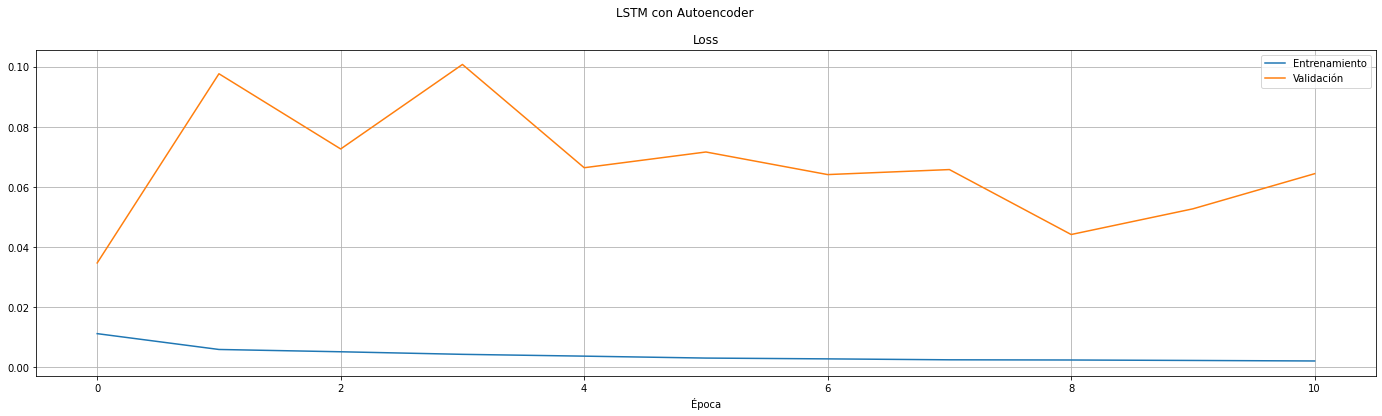

In [66]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("LSTM con Autoencoder")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

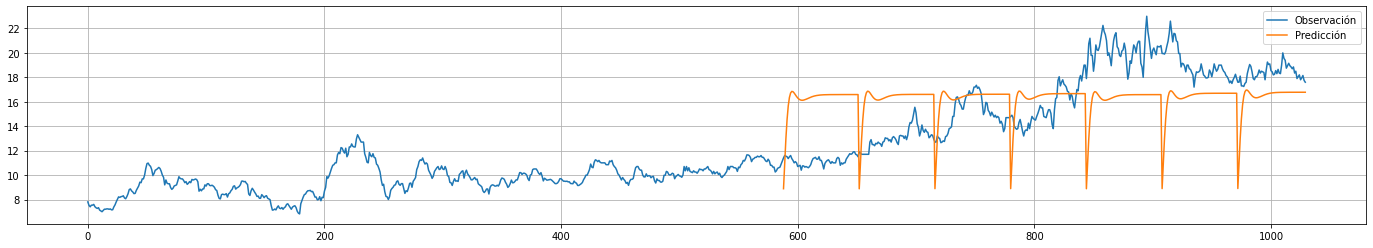

MSE: 402.105 
RMSE: 20.053 
MAE: 15.838 
MAPE: 41.245 
R2: -1.498 


In [67]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('lstm_autoenc_best.h5')
history,predictions = predict_with_rnn2(model,scaler,train,test)
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [68]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["LSTM-Autoencoder"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "LSTM Autoencoder (sin reentrenar)"
}

Tiempo de Entrenamiento: 37.40004587800013
Tiempo de Predicción: 3.1523871290000898


### Modelo CNN

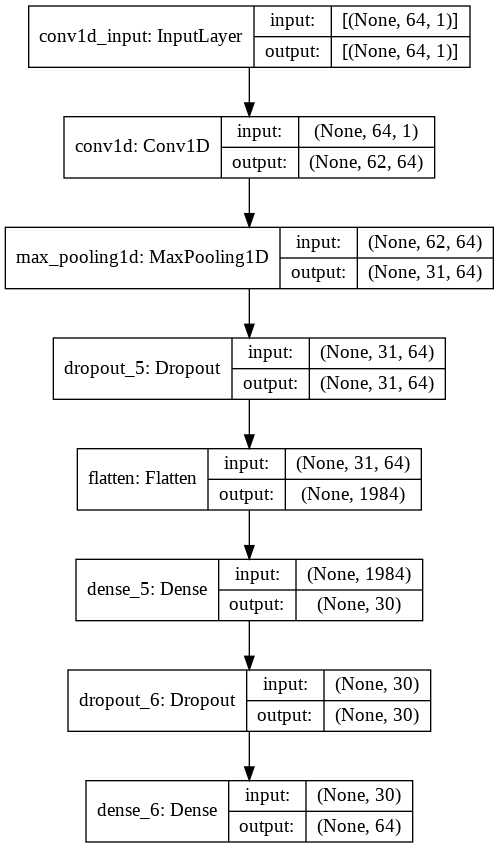

In [69]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu',
input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(tf.keras.layers.MaxPool1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(STEPS_TO_PREDICT))
model.compile(optimizer='adam', loss='mse')

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [70]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('cnn_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 1s 5ms/step - loss: 0.0342 - val_loss: 0.0644
Epoch 2/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0709
Epoch 3/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0068 - val_loss: 0.0401
Epoch 4/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0140
Epoch 5/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0179
Epoch 6/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0078
Epoch 7/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0094
Epoch 8/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0125
Epoch 9/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0157
Epoch 10/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0032 - val_lo

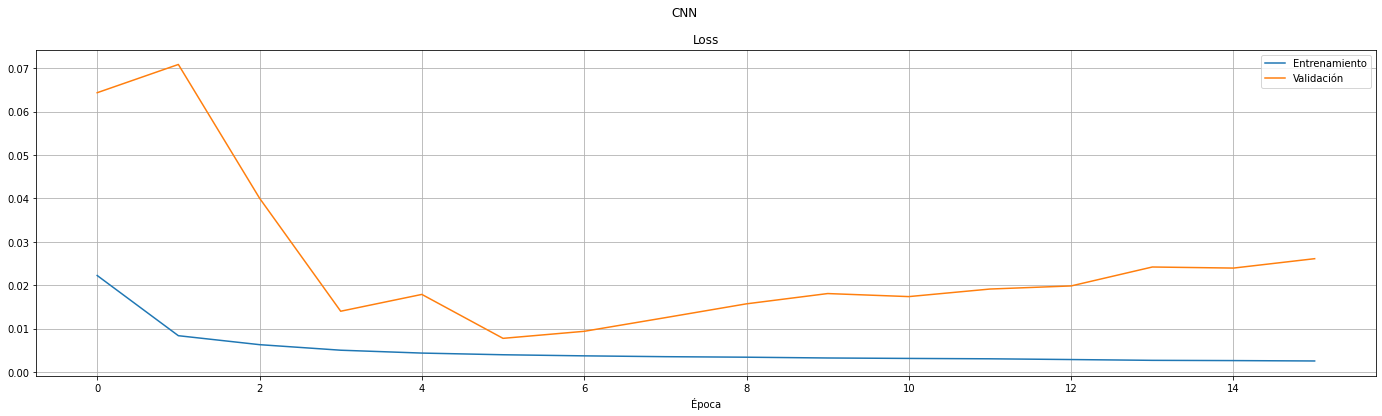

In [71]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("CNN")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

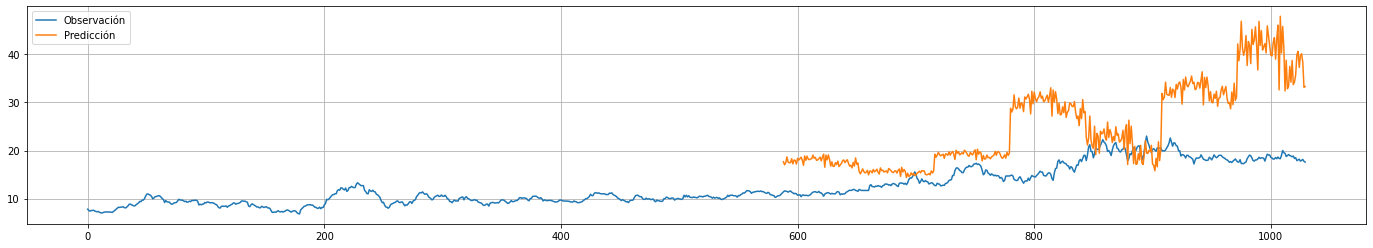

MSE: 110.645 
RMSE: 10.519 
MAE: 8.465 
MAPE: 25.037 
R2: 0.313 


In [72]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('cnn_best.h5')
history,predictions = predict_with_rnn(model,scaler,train,test)
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [73]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["CNN"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "CNN (sin reentrenar)"
}

Tiempo de Entrenamiento: 7.540389727000274
Tiempo de Predicción: 0.5014217100001588


### Modelo Prophet

In [104]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from fbprophet import Prophet

In [105]:
def prepare_for_prophet(series,series_col):
  df_prophet = series.to_frame()
  df_prophet['ds'] = df_prophet.index
  df_prophet = df_prophet.rename(columns={series_col: 'y'})
  df_prophet = df_prophet.reset_index()
  df_prophet.drop('Date', inplace=True, axis=1)
  df_prophet.head()
  return df_prophet

train_prophet = prepare_for_prophet(train,series_col)

#### Con Estacionalidad Diaria

In [106]:
start_time=timeit.default_timer()
model = Prophet(daily_seasonality=True)
model = model.fit(train_prophet)
training_time = timeit.default_timer() - start_time

start_time=timeit.default_timer()
future = model.make_future_dataframe(periods=len(test),freq='D',include_history=False)
forecast = model.predict(future)
prediction_time = timeit.default_timer() - start_time

(<Figure size 1728x432 with 1 Axes>,)

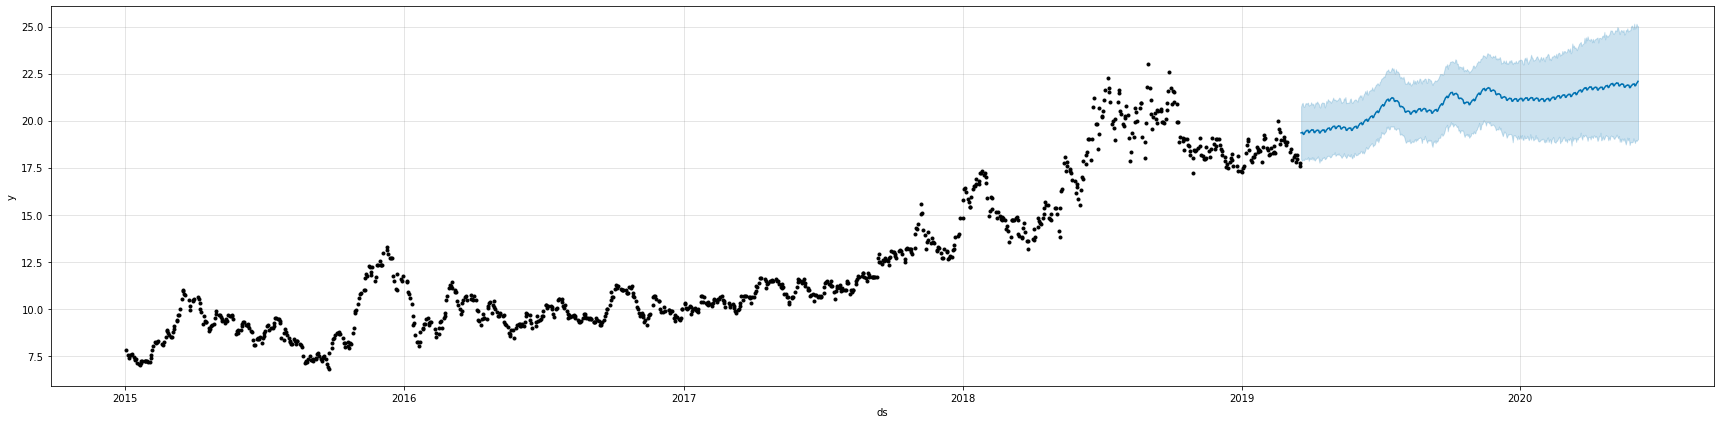

In [107]:
fig,axes=plt.subplots(1,1,figsize=(24,6))
model.plot(forecast,ax=axes),

(<Figure size 648x864 with 4 Axes>,)

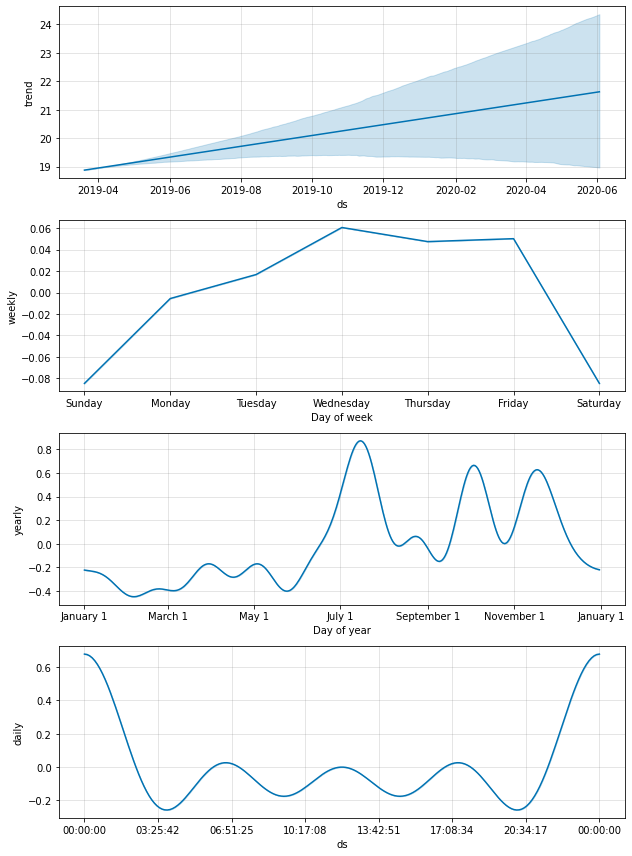

In [108]:
model.plot_components(forecast),

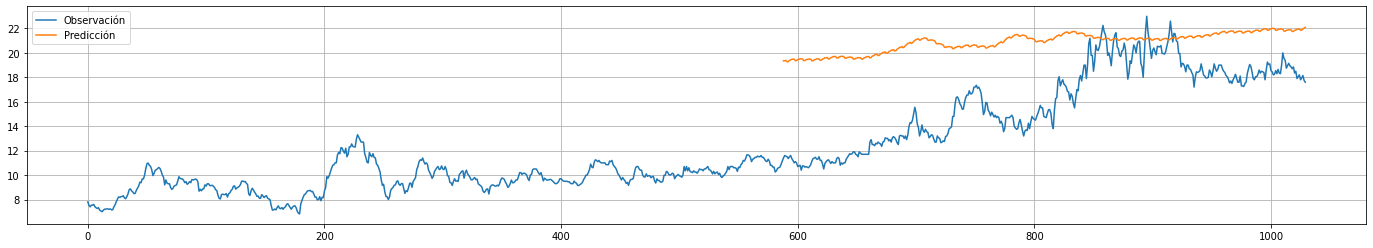

MSE: 265.914 
RMSE: 16.307 
MAE: 12.577 
MAPE: 33.199 
R2: -0.652 


In [109]:
history = [x for x in train.values]
predictions = [x for x in forecast.yhat]
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [110]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["Prophet"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Prophet (con estacionalidad diaria)"
}

Tiempo de Entrenamiento: 0.7991898319996835
Tiempo de Predicción: 2.8040095960000144


#### Sin Estacionalidad Diaria

In [111]:
start_time=timeit.default_timer()
model = Prophet(daily_seasonality=False)
model = model.fit(train_prophet)
training_time = timeit.default_timer() - start_time

start_time=timeit.default_timer()
future = model.make_future_dataframe(periods=len(test),freq='D',include_history=False)
forecast = model.predict(future)
prediction_time = timeit.default_timer() - start_time

(<Figure size 1728x432 with 1 Axes>,)

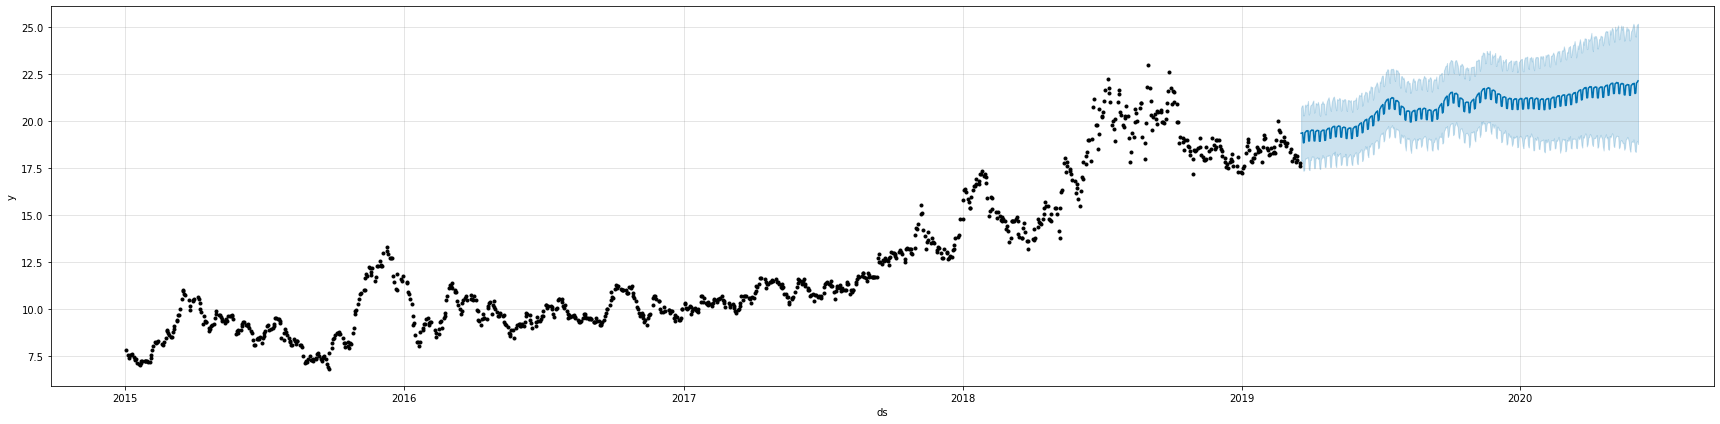

In [112]:
fig,axes=plt.subplots(1,1,figsize=(24,6))
model.plot(forecast,ax=axes),

(<Figure size 648x648 with 3 Axes>,)

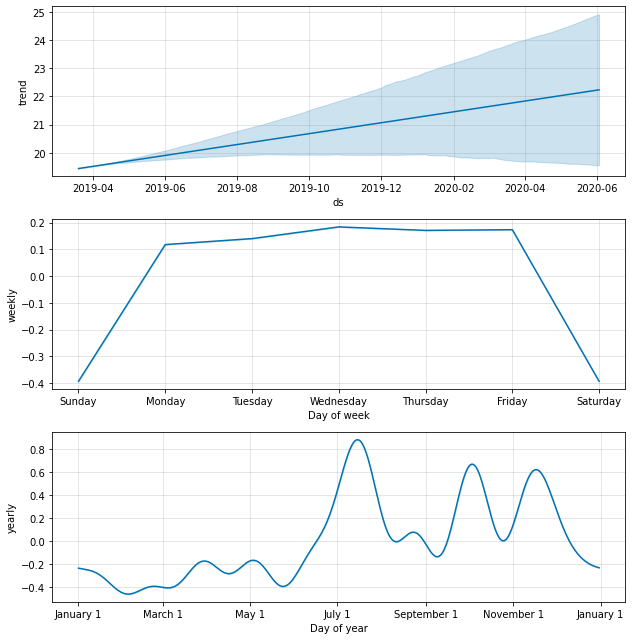

In [113]:
model.plot_components(forecast),

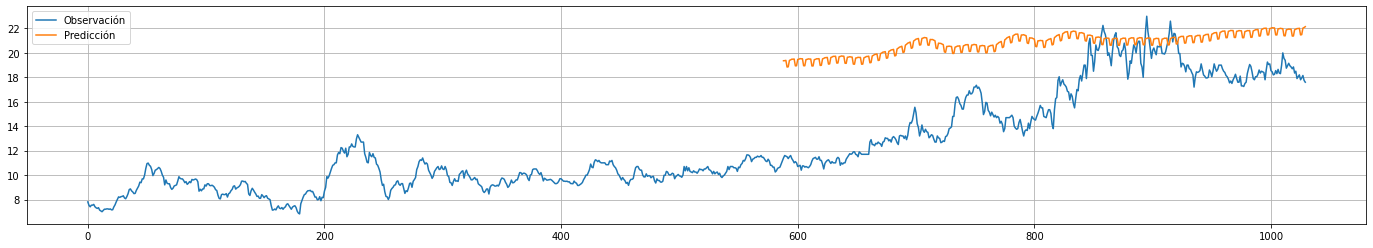

MSE: 267.860 
RMSE: 16.366 
MAE: 12.618 
MAPE: 33.238 
R2: -0.664 


In [114]:
history = [x for x in train.values]
predictions = [x for x in forecast.yhat]
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [115]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["Prophet-NDS"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Prophet (sin estacionalidad diaria)"
}

Tiempo de Entrenamiento: 0.46586447199979375
Tiempo de Predicción: 2.8597310319996723


## Resultados y conclusiones

In [116]:
model_metrics_df = pd.DataFrame.from_dict(model_metric_results, orient='index')
model_metrics_df.sort_values("RMSE",ascending=True)

,MSE,RMSE,MAE,MAPE,R2,Tiempo de Entrenamiento,Tiempo de Predicción,Descripción
ARIMA,7.770072,7.770072,6.083144,19.314586,0.624991,3.374228,26.851008,"ARIMA (p=10,d=1,q=1)"
baseline,7.915971,7.915971,6.161426,19.487578,0.610776,0.000000,0.000210,Modelo de base (Persistencia)
CNN,10.518807,10.518807,8.464948,25.036543,0.312734,7.540390,0.501422,CNN (sin reentrenar)
GRU,13.004758,13.004758,10.432283,28.678565,-0.050500,19.531194,1.365752,GRU (sin reentrenar)
Prophet,16.306881,16.306881,12.577351,33.198582,-0.651709,0.799190,2.804010,Prophet (con estacionalidad diaria)
Prophet-NDS,16.366439,16.366439,12.618079,33.237978,-0.663796,0.465864,2.859731,Prophet (sin estacionalidad diaria)
LSTM,17.072769,17.072769,13.369523,35.067643,-0.810505,20.740554,1.456706,LSTM (sin reentrenar)
LSTM-Autoencoder,20.052568,20.052568,15.838435,41.244565,-1.497651,37.400046,3.152387,LSTM Autoencoder (sin reentrenar)
LSTM-Bi,21.160453,21.160453,16.946196,44.506050,-1.781260,87.266632,2.525650,LSTM Bidireccional (sin reentrenar)


## Bibliografía y Referencias

- [1] "Hands-On Time Series Analysis with Python. From Basics to Bleeding Edge Techniques" - B V VIshwas, Ashish Patel. Apress (2020).
- [2] "Machine Learning for Time Series Forecasting with Python" - Francesca Lazzeri. Wiley (2021).
- [3] "Practical Time Series Analyisis". Avish Pal PKS Prackash. Packt (2017).


